## Libraries

In [1]:
import abc
import codecs
import inspect
import json
import logging
import gc
import os
import pickle
import random
import sys
import time
import warnings

import catboost as cat
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from abc import abstractmethod
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence

from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook

## Config

In [2]:
cat_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - PastActivity

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "classwise_cat"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    loss_function: "RMSE"
    task_type: "CPU"
    iterations: 6000
    early_stopping_rounds: 100
    random_seed: 42

  train_params:
    mode: "regression"
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''


lgb_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - PastActivity

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "classwise_lgbm"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    objective: "regression"
    metric: "rmse"
    boosting_type: "gbdt"
    max_depth: -1
    num_leaves: 256
    tree_learner: "serial"
    learning_rate: 0.01
    subsample: 0.7
    subsample_freq: 1
    colsample_bytree: 0.5
    max_bin: 255
    seed: 71
    bagging_seed: 71
    feature_fraction_seed: 71
    drop_seed: 71
    verbose: -1
    n_jobs: -1
    first_metric_only: False

  train_params:
    num_boost_round: 10000
    early_stopping_rounds: 100
    verbose_eval: 100
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 222

output_dir: "output"
'''

In [3]:
cat_config = dict(yaml.load(cat_conf_string, Loader=yaml.SafeLoader))
lgb_config = dict(yaml.load(lgb_conf_string, Loader=yaml.SafeLoader))

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    
seed_everything(42)

## Functions and Classes

### utils

#### checker

In [5]:
def feature_existence_checker(feature_path: Path,
                              feature_names: List[str]) -> bool:
    features = [f.name for f in feature_path.glob("*.ftr")]
    for f in feature_names:
        if f + "_train.ftr" not in features:
            return False
        if f + "_valid.ftr" not in features:
            return False
        if f + "_test.ftr" not in features:
            return False
    return True

#### jsonutil

In [6]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [7]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [8]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

#### visualization

In [9]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_path: Path = Path("./")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)

    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        #            title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                fontsize=20,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path)

### validation

In [10]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = KFold(
        n_splits=params["n_splits"],
        random_state=params["random_state"],
        shuffle=True)
    uniq_groups = groups.unique()
    split = []
    for trn_grp_idx, val_grp_idx in kf.split(uniq_groups):
        trn_grp = uniq_groups[trn_grp_idx]
        val_grp = uniq_groups[val_grp_idx]
        trn_idx = df[df["group"].isin(trn_grp)].index.values
        val_idx = df[df["group"].isin(val_grp)].index.values
        split.append((trn_idx, val_idx))

    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        groups = df["group"]
        return func(df, groups, config)
    else:
        return func(df, config)

#### feature_selection

In [11]:
def select_features(cols: List[str], feature_importance: pd.DataFrame,
                    config: dict) -> List[str]:
    if config["val"].get("n_delete") is None:
        return cols

    n_delete = config["val"].get("n_delete")
    importance_sorted_cols = feature_importance.sort_values(
        by="value", ascending=False)["feature"].tolist()
    if isinstance(n_delete, int):
        remove_cols = importance_sorted_cols[:n_delete]
        for col in remove_cols:
            cols.remove(col)
    elif isinstance(n_delete, float):
        n_delete_int = int(n_delete * len(importance_sorted_cols))
        remove_cols = importance_sorted_cols[:n_delete_int]
        for col in remove_cols:
            cols.remove(col)
    return cols

### sampling

#### factory

In [12]:
def smote(x_trn: np.ndarray, y_trn: np.ndarray,
          config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    sm = SMOTE(
        k_neighbors=params["k_neighbors"], random_state=params["random_state"])
    sampled_x, sampled_y = sm.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample(x_trn: np.ndarray, y_trn: np.ndarray,
                        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    acc_0 = (y_trn == 0).sum().astype(int)
    acc_1 = (y_trn == 1).sum().astype(int)
    acc_2 = (y_trn == 2).sum().astype(int)
    acc_3 = (y_trn == 3).sum().astype(int)
    rus = RandomUnderSampler({
        0: int(params["acc_0_coef"] * acc_0),
        1: int(params["acc_1_coef"] * acc_1),
        2: int(params["acc_2_coef"] * acc_2),
        3: int(params["acc_3_coef"] * acc_3)
    },
                             random_state=params["random_state"])
    sampled_x, sampled_y = rus.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample_and_smote(
        x_trn: np.ndarray, y_trn: np.ndarray,
        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    sampled_x, sampled_y = random_under_sample(x_trn, y_trn, config)
    sampled_x, sampled_y = smote(sampled_x, sampled_y, config)
    return sampled_x, sampled_y


def get_sampling(x_trn: np.ndarray, y_trn: np.ndarray,
                 config: dict) -> Tuple[np.ndarray, np.ndarray]:
    if config["model"]["sampling"]["name"] == "none":
        return x_trn, y_trn

    policy = config["model"]["sampling"]["name"]
    func = globals().get(policy)
    if func is None:
        raise NotImplementedError
    return func(x_trn, y_trn, config)

### evaluation

#### metrics

In [13]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [14]:
class OptimizedRounder(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]
        self.reverse = reverse

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.4), (0.4, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            if self.reverse:
                search = reversed(range(3))
            else:
                search = iter(range(3))
            for idx in search:
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p

#### cat

In [15]:
class CatBoostOptimizedQWKMetric(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.reverse = reverse

    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(
            n_classwise=self.n_classwise,
            n_overall=self.n_overall,
            reverse=self.reverse)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

#### lgbm

In [16]:
def lgb_classification_qwk(y_pred: np.ndarray,
                           data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_regression_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = (data.get_label() * 3).astype(int)
    y_pred = y_pred.reshape(-1)

    OptR = OptimizedRounder(n_classwise=5, n_overall=5)
    OptR.fit(y_pred, y_true)

    y_pred = OptR.predict(y_pred).astype(int)
    qwk = calc_metric(y_true, y_pred)

    return "qwk", qwk, True


def lgb_residual_qwk_closure(mean_target: np.ndarray):
    def lgb_residual_qwk(y_pred: np.ndarray,
                         data: lgb.Dataset) -> Tuple[str, float, bool]:
        y_true = (data.get_label() * 3).astype(int)
        y_pred = y_pred.reshape(-1)

        y_true = (y_true + mean_target).astype(int)
        y_pred = y_pred + mean_target

        OptR = OptimizedRounder(n_classwise=5, n_overall=5)
        OptR.fit(y_pred, y_true)

        y_pred = OptR.predict(y_pred).astype(int)
        qwk = calc_metric(y_true, y_pred)

        return "qwk", qwk, True

    return lgb_residual_qwk

### models

#### classwise

In [17]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class ClassWiseBase(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS,
            valid_sets: List[Tuple[AoD, AoS]],
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
                     test_preds: np.ndarray,
                     config: dict) -> Tuple[List[np.ndarray], np.ndarray]:
        return [p[0] for p in preds_set], test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           y_valid: AoS,
           valid_features: AoD,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True) -> Tuple[Dict[int, List[Model]], np.ndarray, np.
                                      ndarray, np.ndarray, dict, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        valid_preds = np.zeros(len(valid_features))

        all_classes = train_features["session_title"].unique()

        classwise_mean_importances = {}
        classwise_best_iteration = {c: 0.0 for c in all_classes}
        classwise_cv_score_list = {c: [] for c in all_classes}
        classwise_models = {c: [] for c in all_classes}

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) else y_train

        X_valid = valid_features.values if isinstance(valid_features, pd.DataFrame) \
            else valid_features
        y_valid = y_valid.values if isinstance(y_valid, pd.Series) else y_valid

        for c in all_classes:
            importances = pd.DataFrame(index=feature_name)
            train_c_idx = train_features.query(
                f"session_title == {c}").index.values
            valid_c_idx = valid_features.query(
                f"session_title == {c}").index.values
            test_c_idx = test_features.query(
                f"session_title == {c}").index.values

            X_c_valid = X_valid[valid_c_idx]
            y_c_valid = y_valid[valid_c_idx]

            print(f"Assessment Class: {c}")

            for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
                print("=" * 15)
                print(f"Fold: {i_fold + 1}")
                print("=" * 15)

                trn_c_idx = np.intersect1d(trn_idx, train_c_idx)
                val_c_idx = np.intersect1d(val_idx, train_c_idx)

                # get train data and valid data
                X_trn = X[trn_c_idx]
                y_trn = y[trn_c_idx]
                X_val = X[val_c_idx]
                y_val = y[val_c_idx]

                # train model
                model, best_score = self.fit(
                    X_trn,
                    y_trn,
                    valid_sets=[(X_val, y_val), (X_c_valid, y_c_valid)],
                    config=config)
                classwise_cv_score_list[c].append(best_score)
                classwise_models[c].append(model)
                classwise_best_iteration[c] += self.get_best_iteration(model)

                # predict oof and test, valid
                oof_preds[val_c_idx] = self.predict(model, X_val).reshape(-1)
                test_preds[test_c_idx] += self.predict(
                    model, test_features.loc[test_c_idx, :]).reshape(-1) / len(
                        folds_ids)
                valid_preds[valid_c_idx] += self.predict(
                    model, X_c_valid).reshape(-1) / len(folds_ids)

                # get feature importances
                importances_tmp = pd.DataFrame(
                    self.get_feature_importance(model),
                    columns=[f"class_{c}_gain_{i_fold+1}"],
                    index=feature_name)
                importances = importances.join(importances_tmp, how="inner")

            # summary of feature importance
            classwise_mean_importances[c] = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process
        [oof_preds, valid_preds], test_preds = self.post_process(
            [(oof_preds, y_train), (valid_preds, y_valid)], test_preds, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        valid_score = calc_metric(y_valid, valid_preds)
        print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            logging.info(f"valid score: {valid_score:.5f}")

        eval_results = {
            "eval_result": {
                "oof_score": oof_score,
                "valid_score": valid_score,
                "cv_results": {},
                "n_data": len(train_features),
                "n_features": len(train_features.columns),
                "best_iterations": {
                    f"Assessment {c}": v
                    for c, v in classwise_best_iteration.items()
                },
                "feature_importances": {}
            }
        }

        for c, v in classwise_cv_score_list.items():
            eval_results["eval_result"]["cv_results"][f"Assessment {c}"] = \
                {f"cv{i + 1}": cv_score for i, cv_score in enumerate(v)}

        for c, fi in classwise_mean_importances.items():
            eval_results["eval_result"]["feature_importances"][
                f"Assessment {c}"] = fi.sort_values(ascending=False).to_dict()

        return (classwise_models, oof_preds, test_preds, valid_preds,
                classwise_mean_importances, eval_results)

#### classwise_cat

In [18]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class ClassWiseCatBoost(ClassWiseBase):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            valid_sets: List[Tuple[np.ndarray, np.ndarray]],
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode

        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"]),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            eval_sets = []
            for x, y in valid_sets:
                eval_sets.append((x, y / self.denominator))
        else:
            model = CatBoostClassifier(**model_params)
            eval_sets = valid_sets

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### classwise_lgbm

In [19]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class ClassWiseLightGBM(ClassWiseBase):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            valid_sets: List[Tuple[np.ndarray, np.ndarray]],
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            eval_sets = []
            for x, y in valid_sets:
                eval_sets.append(lgb.Dataset(x, label=y / self.denominator))

        d_train = lgb.Dataset(x_train, label=y_train)

        feval = lgb_regression_qwk if (
            mode == "regression") else lgb_classification_qwk
        model = lgb.train(
            params=model_params,
            train_set=d_train,
            valid_sets=eval_sets,
            feval=feval,
            **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### factory

In [20]:
def classwise_cat() -> ClassWiseCatBoost:
    return ClassWiseCatBoost()


def classwise_lgbm() -> ClassWiseLightGBM:
    return ClassWiseLightGBM()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

### features

#### modules

In [21]:
class TargetEncoder():
    def __init__(self, n_splits: int = 5, random_state: int = 128):
        self.class_dict: Dict[str, List[float]] = {}
        self.column = ""
        self.n_splits = n_splits
        self.random_state = random_state

    def transform(self, X_: pd.DataFrame) -> np.ndarray:
        kf = KFold(
            n_splits=self.n_splits,
            random_state=self.random_state,
            shuffle=True)
        X = X_.copy()
        X = X.reset_index(drop=True)
        converted = np.zeros(len(X))
        for i, (_, v_idx) in enumerate(kf.split(X)):
            converted[v_idx] = X.loc[v_idx, self.column].map(
                lambda x: self.class_dict[x][i])
        return converted

    def fit_transform(self, X_: pd.DataFrame, y: Union[pd.Series, np.ndarray],
                      column: str) -> np.ndarray:
        self.column = column
        uniq_class = X_[column].unique()
        for c in uniq_class:
            self.class_dict[c] = []
        kf = StratifiedKFold(
            n_splits=self.n_splits,
            shuffle=True,
            random_state=self.random_state)
        X = X_.copy()
        X = X.reset_index(drop=True)
        yy = y.values if isinstance(y, pd.Series) else y
        converted = np.zeros(len(X))
        # import pdb
        # pdb.set_trace()
        for t_idx, v_idx in kf.split(X, y):
            X_t = X.loc[t_idx, column]
            y_t = yy[t_idx]
            X_v = X.loc[v_idx, column]
            cvtd = converted[v_idx]

            for c in uniq_class:
                target_mean = y_t[X_t == c].mean()
                self.class_dict[c].append(target_mean)
                cvtd[X_v == c] = target_mean
            converted[v_idx] = cvtd
        return converted

#### base

In [22]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        Path(self.save_dir).mkdir(exist_ok=True, parents=True)
        self.train = pd.DataFrame()
        self.valid = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.ftr"
        self.valid_path = Path(self.save_dir) / f"{self.name}_valid.ftr"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.ftr"

    def run(self,
            train_df: pd.DataFrame,
            test_df: Optional[pd.DataFrame] = None,
            log: bool = False):
        with timer(self.name, log=log):
            self.create_features(train_df, test_df)
            prefix = self.prefix + "_" if self.prefix else ""
            suffix = self.suffix + "_" if self.suffix else ""
            self.train.columns = pd.Index([str(c) for c in self.train.columns])
            self.valid.columns = pd.Index([str(c) for c in self.valid.columns])
            self.test.columns = pd.Index([str(c) for c in self.test.columns])
            self.train.columns = prefix + self.train.columns + suffix
            self.valid.columns = prefix + self.valid.columns + suffix
            self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df: pd.DataFrame,
                        test_df: Optional[pd.DataFrame]):
        raise NotImplementedError

    def save(self):
        self.train.to_feather(str(self.train_path))
        self.valid.to_feather(str(self.valid_path))
        self.test.to_feather(str(self.test_path))


class PartialFeature(metaclass=abc.ABCMeta):
    def __init__(self):
        self.df = pd.DataFrame

    @abc.abstractmethod
    def create_features(self, df: pd.DataFrame, test: bool = False):
        raise NotImplementedError


def is_feature(klass) -> bool:
    return "is_feature" in set(dir(klass))


def get_features(namespace: dict):
    for v in namespace.values():
        if inspect.isclass(v) and is_feature(v) and not inspect.isabstract(v):
            yield v()


def generate_features(train_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      namespace: dict,
                      required: list,
                      overwrite: bool,
                      log: bool = False):
    for f in get_features(namespace):
        if (f.name not in required) or (f.train_path.exists()
                                        and f.valid_path.exists()
                                        and f.test_path.exists()
                                        and not overwrite):
            if not log:
                print(f.name, "was skipped")
            else:
                logging.info(f"{f.name} was skipped")
        else:
            f.run(train_df, test_df, log).save()


def load_features(
        config: dict) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    feather_path = config["dataset"]["feature_dir"]

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_train.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_train.ftr").exists()
    ]
    x_train = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_valid.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_valid.ftr").exists()
    ]
    x_valid = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_test.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_test.ftr").exists()
    ]
    x_test = pd.concat(dfs, axis=1)
    return x_train, x_valid, x_test

#### unified_modify

In [39]:
IoF = Union[int, float]


class PastActivity(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()

        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_valid: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []
        for ins_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train past game"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feat_df, _ = past_activity_features(user_sample, test=False)
            compiled_data_train.append(feat_df)

        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test past game"):
            feat_df, valid_df = past_activity_features(user_sample, test=True)
            compiled_data_valid.append(valid_df)
            compiled_data_test.append(feat_df)
        self.valid = pd.concat(compiled_data_valid, axis=0, sort=False)
        self.valid.reset_index(drop=True, inplace=True)
        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test.reset_index(drop=True, inplace=True)


def past_activity_features(user_sample: pd.DataFrame, test: bool = False
                           ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    activity_codes_map = {
        "Bottle Filler (Activity)": [
            2020, 3010, 4030, 3110, 4020, 4035,
            2030, 4070, 4090, 4080, 2010],
        "Bug Measurer (Activity)": [
            3010, 4030, 3110, 4035, 4025, 4070, 4090, 4080
        ],
        "Chicken Balancer (Activity)": [
            3010, 3110, 4070, 4030, 4020, 4035, 4022, 4090, 4080
        ],
        "Egg Dropper (Activity)": [
            3010, 2020, 3110, 4025, 4020, 4070, 4090, 4080
        ],
        "Fireworks (Activity)": [
            3010, 4030, 4020, 3110, 4070, 4090, 4080
        ],
        "Flower Waterer (Activity)": [
            3010, 4070, 3110, 4030, 4020, 4025, 4022, 4090, 4080
        ],
        "Sandcastle Builder (Activity)": [
            3010, 3110, 4070, 4090, 4030,
            4035, 4021, 4020, 4080, 2010
        ],
        "Watering Hole (Activity)": [
            3010, 3110, 4021, 4020, 4025, 4070,
            5000, 5010, 4090, 2010
        ]
    }

    activity_columns_map: Dict[str, Dict[str, Union[str, List[str]]]] = {
        "Bottle Filler (Activity)": {
            "round": "max",
            "identifier": [
                "addToYourCollection", "Dot_AllDoneTapThis",
                "ifYouWantToTry", "niceJob", "thatLooksSoCool",
                "oohStripes", "wowSoCool", "Dot_TrySomethingNew",
                "andItsFull", "ohWow", "dragABottle"],
            "jar_filled": ["True", "False"]
        },
        "Bug Measurer (Activity)": {
            "identifier": [
                "sid_bugtank_line22",
                "sid_bugtank_line21", "sid_bugtank_line8_ALT",
                "sid_1", "sid_2", "sid_3", "sid_4", "sid_5",
                "sid_6", "sid_7", "sid_bugtank_line20",
                "sid_bugtank_line3", "Dot_TrySomethingNew"]
        },
        "Chicken Balancer (Activity)": {
            "identifier": [
                'pig,whathappens,idle', 'morechicksheavier',
                'Dot_AllDoneTapThis', 'pigisheavy,chickiesarelight,idle',
                'watchtheseesaw,idle', 'dragchicks',
                'Dot_TrySomethingNew', 'piglovestriangles'],
            "layout.left.pig": ["True", "False"],
            "layout.right.pig": ["True", "False"]
        },
        "Egg Dropper (Activity)": {
            "identifier": [
                "Buddy_Incoming", "Buddy_MoreThanOneEgg",
                "Buddy_TapDino", "Buddy_TryDifferentNest",
                "Buddy_EggsWentToOtherNest", "Buddy_TapToSwitch"
            ]
        },
        "Fireworks (Activity)": {
            "identifier": [
                "Dot_GreatJob", "Dot_SoHigh",
                "Dot_Wow", "Dot_Amazing", "Dot_AllDoneTapThis",
                "Dot_SoLow", "Dot_WhoaSoCool", "Dot_GoLower",
                "Dot_TrySomethingNew", "Dot_UseFinger", "Dot_GoHigher"
            ],
            "launched": ["True", "False"]
        },
        "Flower Waterer (Activity)": {
            "identifier": [
                "Dot_AllDoneTapThis", "basket",
                "tallflower", "plantastic", "leangreen",
                "greenthumb", "Dot_TrySomethingNew"
            ]
        },
        "Sandcastle Builder (Activity)": {
            "identifier": [
                "Dot_DragShovel", "Dot_AllDoneTapThis",
                "Dot_DragMoldPlace", "Dot_SoCool", "Dot_TryWall",
                "Dot_MoldSmall", "Dot_TrySomethingNew",
                "Dot_GreatJob", "Dot_FillItUp", "Dot_TryTower",
                "Dot_MoldBig"
            ],
            "filled": ["True", "False"]
        },
        "Watering Hole (Activity)": {
            "identifier": [
                "Buddy_FillClouds",
                "Buddy_NoWaterLeft,Buddy_FillClouds",
                "Buddy_TaptoStartShower",
                "Dot_AllDoneTapThis", "Buddy_BigClout",
                "Buddy_SmallCloud", "Buddy_KeepMakingItRain",
                "Dot_TrySomethingNew"
            ],
            "filled": ["True", "False"]
        }
    }

    all_assessments: List[Dict[str, IoF]] = []
    past_activity_summarys: Dict[str, List[Dict[str, IoF]]] = {
        title: []
        for title in activity_codes_map.keys()
    }
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        if ((sess["type"].iloc[0] != "Assessment")
                and (sess["type"].iloc[0] != "Activity")):
            continue

        if sess["type"].iloc[0] == "Activity":
            act_title = sess["title"].iloc[0]
            event_data = get_event_data(sess)

            columns = activity_columns_map[act_title]
            codes = activity_codes_map[act_title]

            summary = {}
            for code in codes:
                summary[str(code)] = (sess["event_code"] == code).sum()

            summary["duration"] = event_data["game_time"].max()
            for key, val in columns.items():
                if val == "max":
                    summary["max_" + key] = max(event_data[key])
                if isinstance(val, list):
                    for v in val:
                        if key not in event_data.columns:
                            summary[key + "_eq_" + v] = 0
                        else:
                            summary[key + "_eq_" + v] = (
                                event_data[key] == v).sum()
            past_activity_summarys[act_title].append(summary)

        if sess["type"].iloc[0] == "Assessment" and (test or len(sess) > 1):
            features: Dict[str, IoF] = {}
            sess_title: str = sess.title.iloc[0]

            for key, summs in past_activity_summarys.items():
                if key == "Bottle Filler (Activity)":
                    if len(summs) == 0:
                        features["max_round"] = 0
                        features[key + "_duration"] = 0
                        features["mean_" + key + "_duration"] = 0
                        features["n_jar_filled_True"] = 0
                        features["n_jar_filled_False"] = 0
                        features["n_jar_filled_ratio"] = 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = 0
                    else:
                        features["max_round"] = max(
                            collect(summs, "max_round"))
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        features["mean_" + key + "_duration"] = \
                            features[key + "_duration"] / features["max_round"]
                        features["n_jar_filled_True"] = sum(
                            collect(summs, "jar_filled_eq_True"))
                        features["n_jar_filled_False"] = sum(
                            collect(summs, "jar_filled_eq_False"))
                        total = features["n_jar_filled_False"] + \
                            features["n_jar_filled_True"]
                        features["n_jar_filled_ratio"] = \
                            features["n_jar_filled_True"] / total \
                                if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + ident))
                elif key == "Chicken Balancer (Activity)":
                    if len(summs) == 0:
                        features["n_layout.left.pig_True"] = 0
                        features["n_layout.right.pig_True"] = 0
                        features["n_layout.left.pig_False"] = 0
                        features["n_layout.right.pig_False"] = 0
                        features["layout.left.pig_ratio"] = 0.0
                        features["layout.right.pig_ratio"] = 0.0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_eq_" + ident + "_count"] = 0
                    else:
                        features["n_layout.left.pig_True"] = sum(
                            collect(summs, "layout.left.pig_eq_True"))
                        features["n_layout.left.pig_False"] = sum(
                            collect(summs, "layout.left.pig_eq_False"))
                        features["n_layout.right.pig_True"] = sum(
                            collect(summs, "layout.right.pig_eq_True"))
                        features["n_layout.right.pig_False"] = sum(
                            collect(summs, "layout.right.pig_eq_False"))
                        total = features["n_layout.left.pig_False"] + \
                            features["n_layout.left.pig_True"]
                        features["layout.left.pig_ratio"] = \
                            features["n_layout.left.pig_True"] / total \
                                if total > 0 else 0
                        total = features["n_layout.right.pig_False"] + \
                            features["n_layout.right.pig_True"]
                        features["layout.right.pig_ratio"] = \
                            features["n_layout.right.pig_True"] / total \
                                if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + ident))
                elif key == "Fireworks (Activity)":
                    if len(summs) == 0:
                        features["n_launched_True"] = 0
                        features["n_launched_False"] = 0
                        features["launched_ratio"] = 0.0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = 0
                    else:
                        features["n_launched_True"] = sum(
                            collect(summs, "launched_eq_True"))
                        features["n_launched_False"] = sum(
                            collect(summs, "launched_eq_False"))
                        total = features["n_launched_False"] + \
                            features["n_launched_True"]
                        features["launched_ratio"] = \
                            features["n_launched_True"] / total \
                                if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + ident))

                elif key == "Sandcastle Builder (Activity)":
                    if len(summs) == 0:
                        features["n_sand_filled_True"] = 0
                        features["n_sand_filled_False"] = 0
                        features["sand_filled_ratio"] = 0.0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = 0
                    else:
                        features["n_sand_filled_True"] = sum(
                            collect(summs, "filled_eq_True"))
                        features["n_sand_filled_False"] = sum(
                            collect(summs, "filled_eq_False"))
                        total = features["n_sand_filled_False"] + \
                            features["n_sand_filled_True"]
                        features["sand_filled_ratio"] = \
                            features["n_sand_filled_True"] / total \
                                if total > 0 else  0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + ident))
                elif key == "Watering Hole (Activity)":
                    if len(summs) == 0:
                        features["n_water_filled_True"] = 0
                        features["n_water_filled_False"] = 0
                        features["water_filled_ratio"] = 0.0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = 0
                    else:
                        features["n_water_filled_True"] = sum(
                            collect(summs, "filled_eq_True"))
                        features["n_water_filled_False"] = sum(
                            collect(summs, "filled_eq_False"))
                        total = features["n_water_filled_False"] + \
                            features["n_water_filled_True"]
                        features["water_filled_ratio"] = \
                            features["n_water_filled_True"] / total \
                                if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + ident))
                else:
                    if len(summs) == 0:
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = 0
                    else:
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + ident + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + ident))

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)"
            ) else 4100
            all_attempts = sess.query(f"event_code == {attempt_code}")
            if len(sess) == 1:
                all_assessments.append(features)
            elif len(all_attempts) > 0:
                all_assessments.append(features)

    if test:
        all_assess_df = pd.DataFrame([all_assessments[-1]])
        valid_df = pd.DataFrame(all_assessments[:-1])
        return all_assess_df, valid_df
    else:
        all_assess_df = pd.DataFrame(all_assessments)
        return all_assess_df, None


def get_event_data(df: pd.DataFrame) -> pd.DataFrame:
    return pd.io.json.json_normalize(df.event_data.apply(json.loads))


def collect(lod: List[Dict[str, IoF]], name: str) -> List[IoF]:
    return [d[name] for d in lod]

## main

### Settings

In [25]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/cat_7_lgb_12.yml"
log_dir = "log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

merged_config = cat_config.copy()
merged_config["lgb_model"] = lgb_config["model"]
merged_config["cat_model"] = cat_config["model"]
merged_config.pop("model")

merged_config["args"] = dict()
merged_config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(merged_config["output_dir"])
feature_dir = Path(merged_config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

merged_config["model_output_dir"] = str(output_dir)

### Data/Feature Loading

In [26]:
input_dir = Path(merged_config["dataset"]["dir"])

if not feature_existence_checker(feature_dir, merged_config["features"]):
    with timer(name="load data", log=True):
        train = pd.read_csv(input_dir / "train.csv")
        test = pd.read_csv(input_dir / "test.csv")

In [40]:
if not feature_existence_checker(feature_dir, merged_config["features"]):
    generate_features(
        train, 
        test, 
        namespace=globals(),
        required=merged_config["features"],
        overwrite=False, 
        log=True)

    del train, test
    gc.collect()

with timer("feature laoding", log=True):
    x_train = pd.concat([
        pd.read_feather(feature_dir / (f + "_train.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_valid = pd.concat([
        pd.read_feather(feature_dir / (f + "_valid.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_test = pd.concat([
        pd.read_feather(feature_dir / (f + "_test.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)

groups = x_train["installation_id"].values
groups_valid = x_valid["installation_id"].values
y_train = x_train["accuracy_group"].values.reshape(-1)
y_valid = x_valid["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

assert len(x_train) == len(y_train)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train)}")
logging.debug(f"numbber of test samples: {len(x_test)}")

RuntimeError: dictionary changed size during iteration

In [38]:
gc.collect()

0

### Adversarial Validation

Fold: 0
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.865512	valid's auc: 0.541642
[200]	train's auc: 0.898631	valid's auc: 0.536335
Early stopping, best iteration is:
[140]	train's auc: 0.883231	valid's auc: 0.548237
Evaluated only: auc
Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.860478	valid's auc: 0.58604
Early stopping, best iteration is:
[4]	train's auc: 0.660225	valid's auc: 0.639116
Evaluated only: auc
Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.860104	valid's auc: 0.491763
Early stopping, best iteration is:
[4]	train's auc: 0.696049	valid's auc: 0.528009
Evaluated only: auc
Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.86878	valid's auc: 0.527994
[200]	train's auc: 0.904103	valid's auc: 0.558825
Early stopping, best iteration is:
[199]	train's auc: 0.903817	valid's auc: 0.558848
Evaluated only: auc
Fold: 

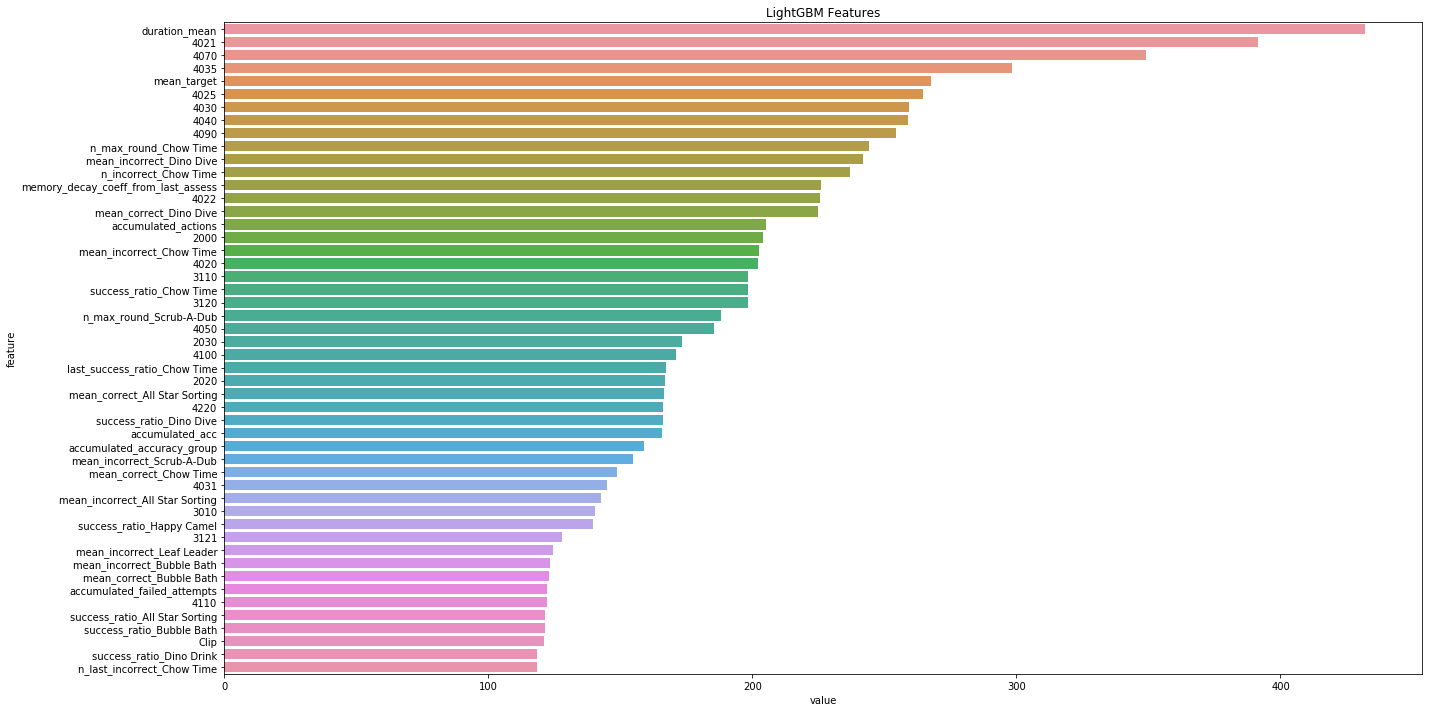

In [29]:
logging.info("Adversarial Validation")
train_adv = x_train.copy()
test_adv = x_valid.copy()

train_adv["target"] = 0
test_adv["target"] = 1
groups_adv = np.concatenate([groups, groups_valid])
train_test_adv = pd.concat([train_adv, test_adv], axis=0,
                           sort=False).reset_index(drop=True)

train_test_adv["group"] = groups_adv
splits = get_validation(train_test_adv, merged_config)
train_test_adv.drop("group", axis=1, inplace=True)

aucs = []
importance = np.zeros(len(cols))
for fold, (trn_idx, val_idx) in enumerate(splits):
    print("=" * 20)
    print(f"Fold: {fold}")
    print("=" * 20)

    x_train_adv = train_test_adv.loc[trn_idx, cols]
    y_train_adv = train_test_adv.loc[trn_idx, "target"]
    x_val_adv = train_test_adv.loc[val_idx, cols]
    y_val_adv = train_test_adv.loc[val_idx, "target"]

    train_lgb = lgb.Dataset(x_train_adv, label=y_train_adv)
    valid_lgb = lgb.Dataset(x_val_adv, label=y_val_adv)

    model_params = merged_config["av"]["model_params"]
    train_params = merged_config["av"]["train_params"]
    clf = lgb.train(
        model_params,
        train_lgb,
        valid_sets=[train_lgb, valid_lgb],
        valid_names=["train", "valid"],
        **train_params)

    aucs.append(clf.best_score)
    importance += clf.feature_importance(
        importance_type="gain") / len(splits)

# Check the feature importance
feature_imp = pd.DataFrame(
    sorted(zip(importance, cols)), columns=["value", "feature"])

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("LightGBM Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_adv.png")

merged_config["av_result"] = dict()
merged_config["av_result"]["score"] = dict()
for i, auc in enumerate(aucs):
    merged_config["av_result"]["score"][f"fold{i}"] = auc

merged_config["av_result"]["feature_importances"] = \
    feature_imp.set_index("feature").sort_values(
        by="value",
        ascending=False
    ).to_dict()["value"]

### Train model

#### CatBoost model 

+++++++++++++++++++++++++
seed: 123
+++++++++++++++++++++++++
Assessment Class: 4
Fold: 1
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 115ms	remaining: 11m 27s
100:	learn: 0.4362526	test: 0.2908185	test1: 0.2404723	best: 0.2404723 (100)	total: 11.6s	remaining: 11m 16s
200:	learn: 0.4790935	test: 0.3202993	test1: 0.2631762	best: 0.2740081 (173)	total: 22.6s	remaining: 10m 52s
300:	learn: 0.5073124	test: 0.3190830	test1: 0.2679967	best: 0.2857214 (230)	total: 33.8s	remaining: 10m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2857213754
bestIteration = 230

Shrink model to first 231 iterations.
Fold: 2
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 112ms	remaining: 11m 9s
100:	learn: 0.4300066	test: 0.3756049	test1: 0.2426125	best: 0.2558450 (98)	total: 11.3s	remaining: 10m 57s
200:	learn: 0.4767010	test: 0.3880951	test1: 0.2868332	best: 0.2887600 (174)	total: 22.8s	remaining: 10m 57s
300:	learn

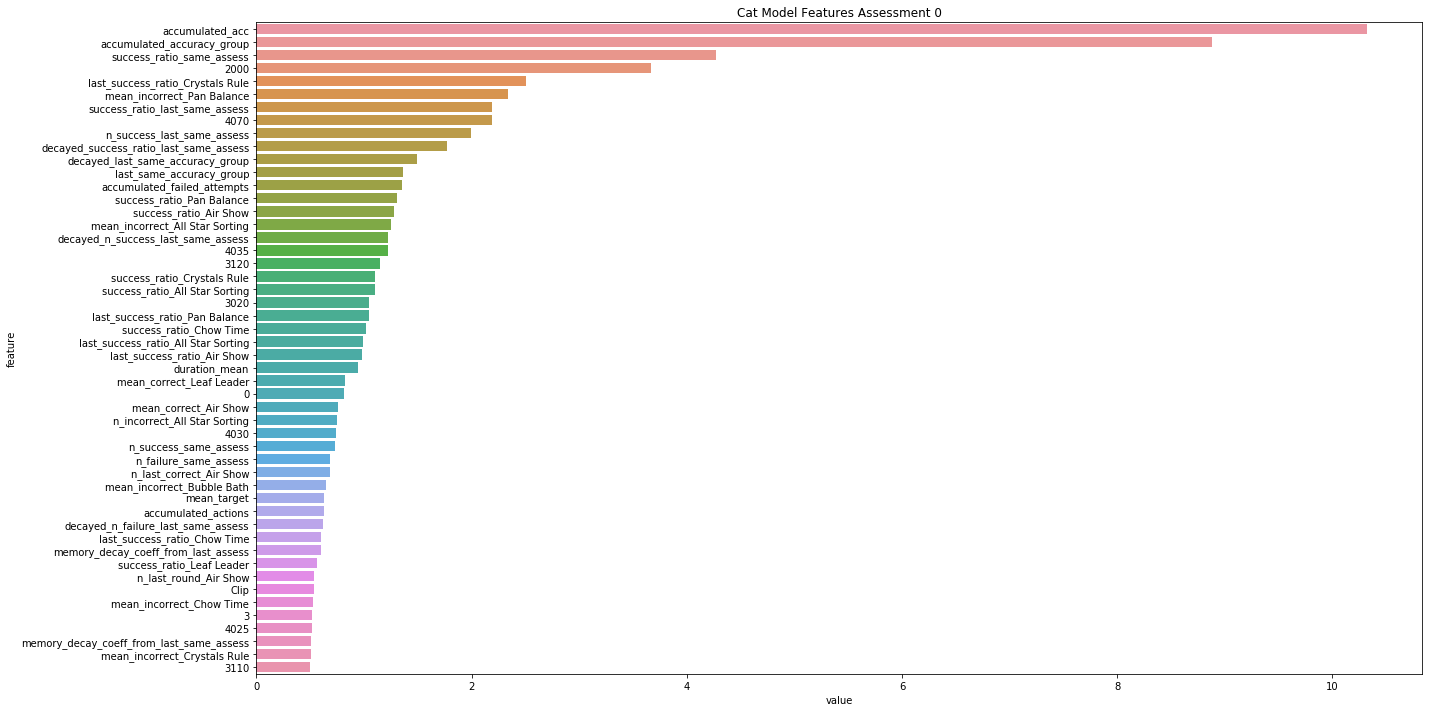

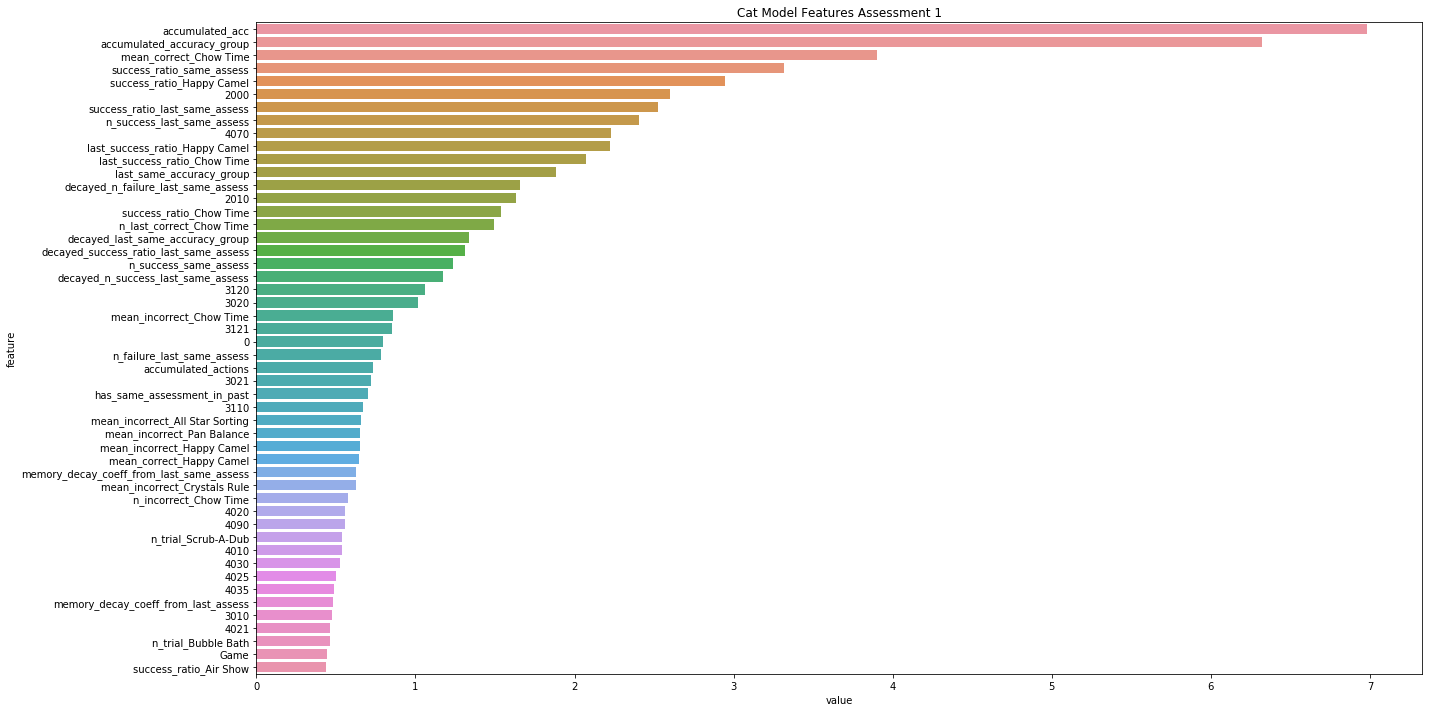

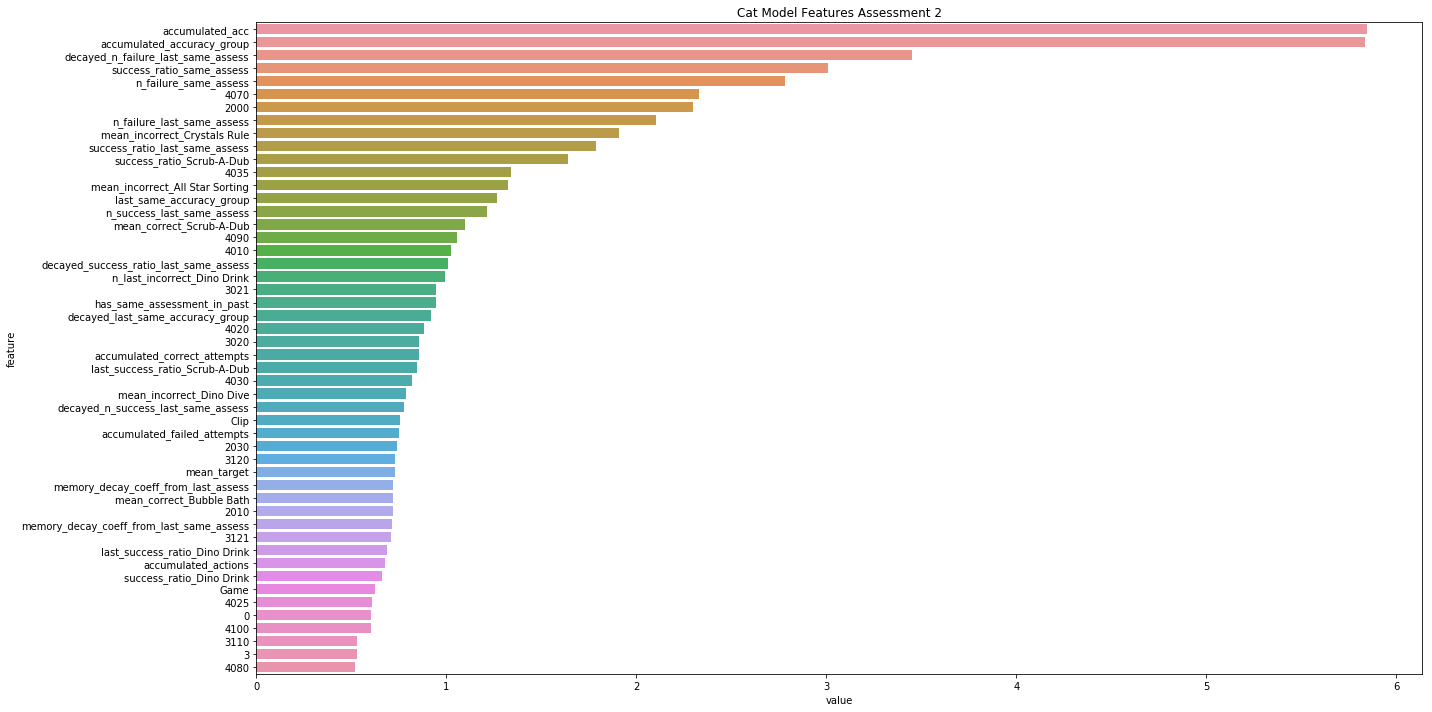

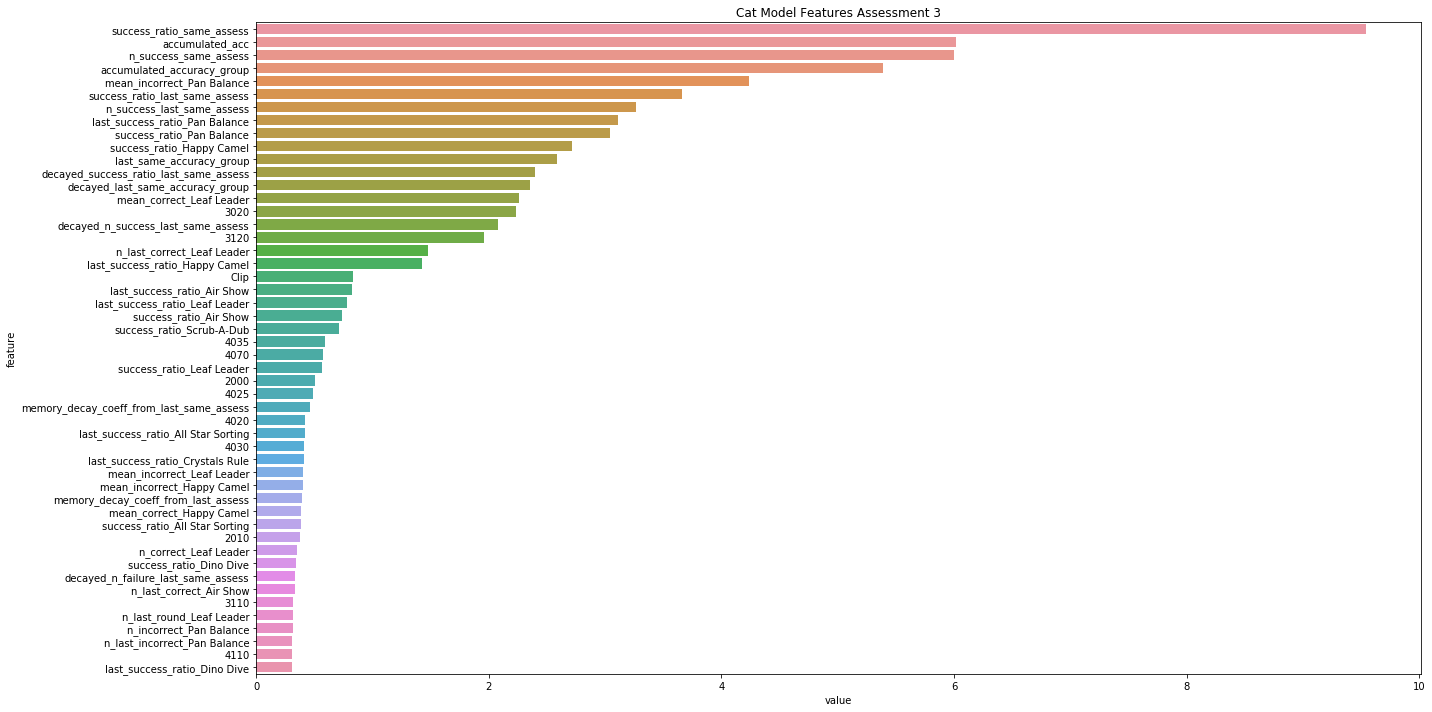

In [35]:
logging.info("Train model")
logging.info("CatBoost model")

model = get_model(cat_config)

avg_oof_preds = np.zeros(len(x_train))
avg_test_preds = np.zeros(len(x_test))
avg_valid_preds = np.zeros(len(x_valid))

importances = {
    i: pd.DataFrame(index=cols) for i in range(5)
}

seed_sets = [123, 456, 789, 101, 215]

for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    cat_config["model"]["model_params"]["random_seed"] = seed
    
    cat_config["val"]["params"]["random_state"] = seed
    
    # get folds
    x_train["group"] = groups
    splits = get_validation(x_train, cat_config)
    x_train.drop("group", axis=1, inplace=True)
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        folds_ids=splits,
        config=cat_config,
        log=True)
    avg_oof_preds += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds += model.raw_valid_preds / (len(seed_sets) * 2)
    
    cat_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        cat_config[f"eval_results_seed{seed}"][k] = v
        
    for i in range(5):
        importances[i] = importances[i].join(
            feature_importance[i].to_frame().rename(
                columns={0: f"seed{seed}"}), how="inner")
    
    

for i in range(5):    
    feature_imp = importances[i].mean(axis=1).reset_index().rename(
        columns={
            "index": "feature",
            0: "value"
        })

    plt.figure(figsize=(20, 10))
    sns.barplot(
        x="value",
        y="feature",
        data=feature_imp.sort_values(by="value", ascending=False).head(50))
    plt.title(f"Cat Model Features Assessment {i}")
    plt.tight_layout()
    plt.savefig(output_dir / f"feature_importance_Cat_Assessment{i}.png")

#### LGBM model

+++++++++++++++++++++++++
seed: 387
+++++++++++++++++++++++++
Assessment Class: 4
Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.33932	valid_0's qwk: 0.319087	valid_1's rmse: 0.327951	valid_1's qwk: 0.285079
[200]	valid_0's rmse: 0.338175	valid_0's qwk: 0.312881	valid_1's rmse: 0.328649	valid_1's qwk: 0.296997
Early stopping, best iteration is:
[115]	valid_0's rmse: 0.338488	valid_0's qwk: 0.334485	valid_1's rmse: 0.327014	valid_1's qwk: 0.295601
Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.361029	valid_0's qwk: 0.397279	valid_1's rmse: 0.327113	valid_1's qwk: 0.259099
[200]	valid_0's rmse: 0.352655	valid_0's qwk: 0.459822	valid_1's rmse: 0.326798	valid_1's qwk: 0.271413
Early stopping, best iteration is:
[168]	valid_0's rmse: 0.354006	valid_0's qwk: 0.450201	valid_1's rmse: 0.326515	valid_1's qwk: 0.312155
Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's

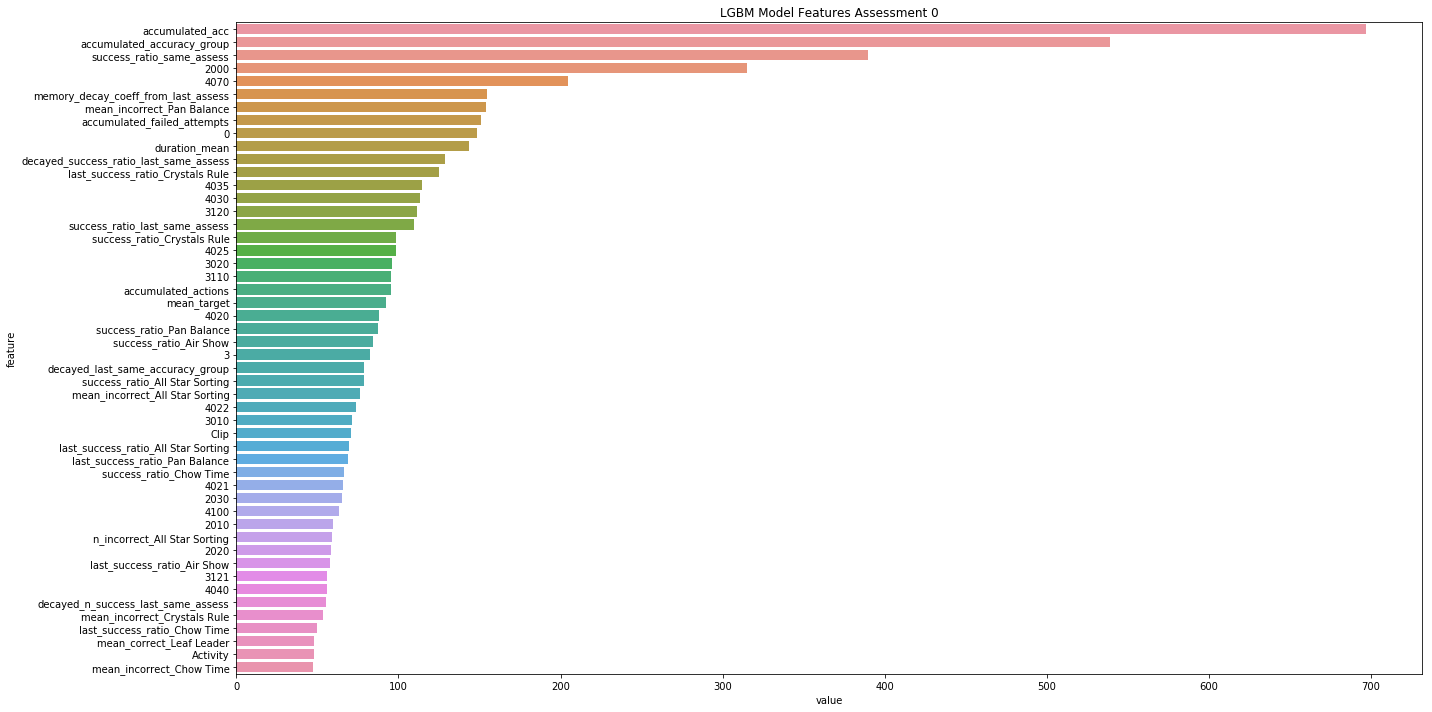

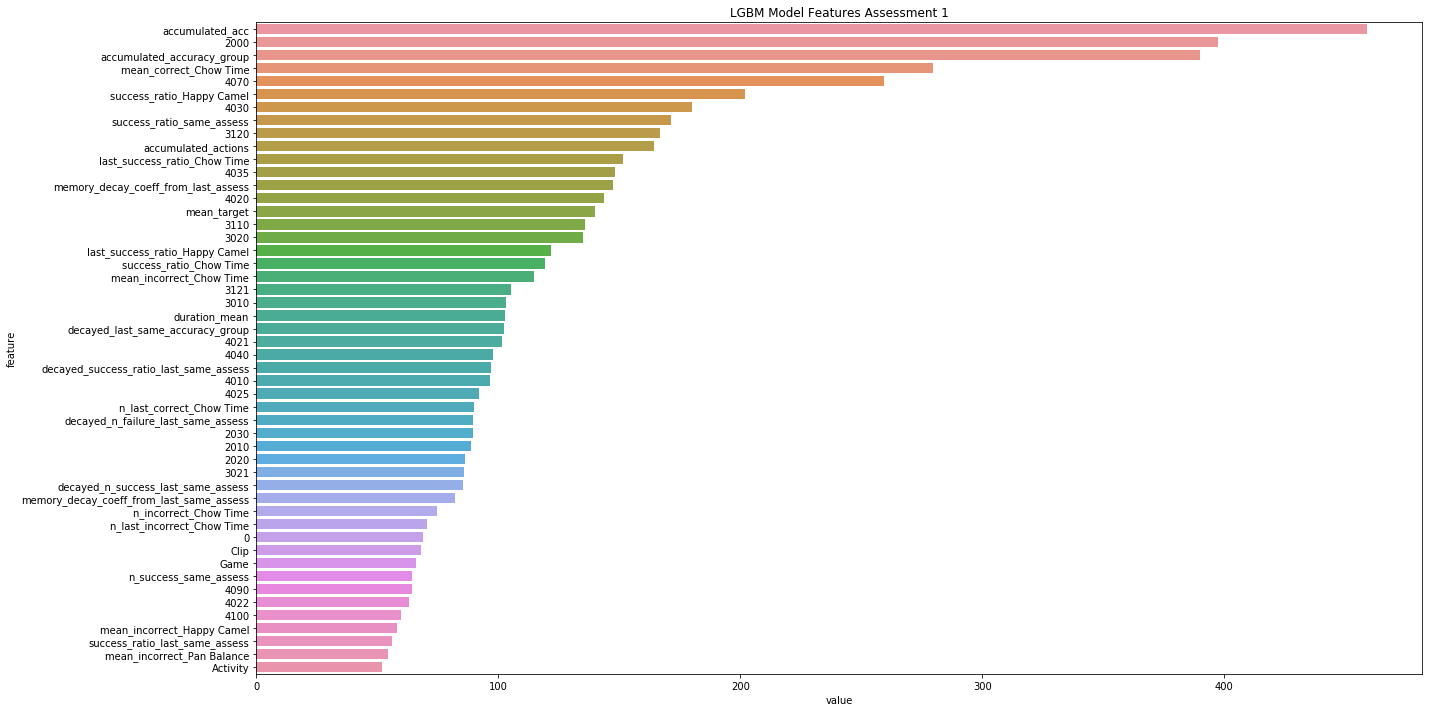

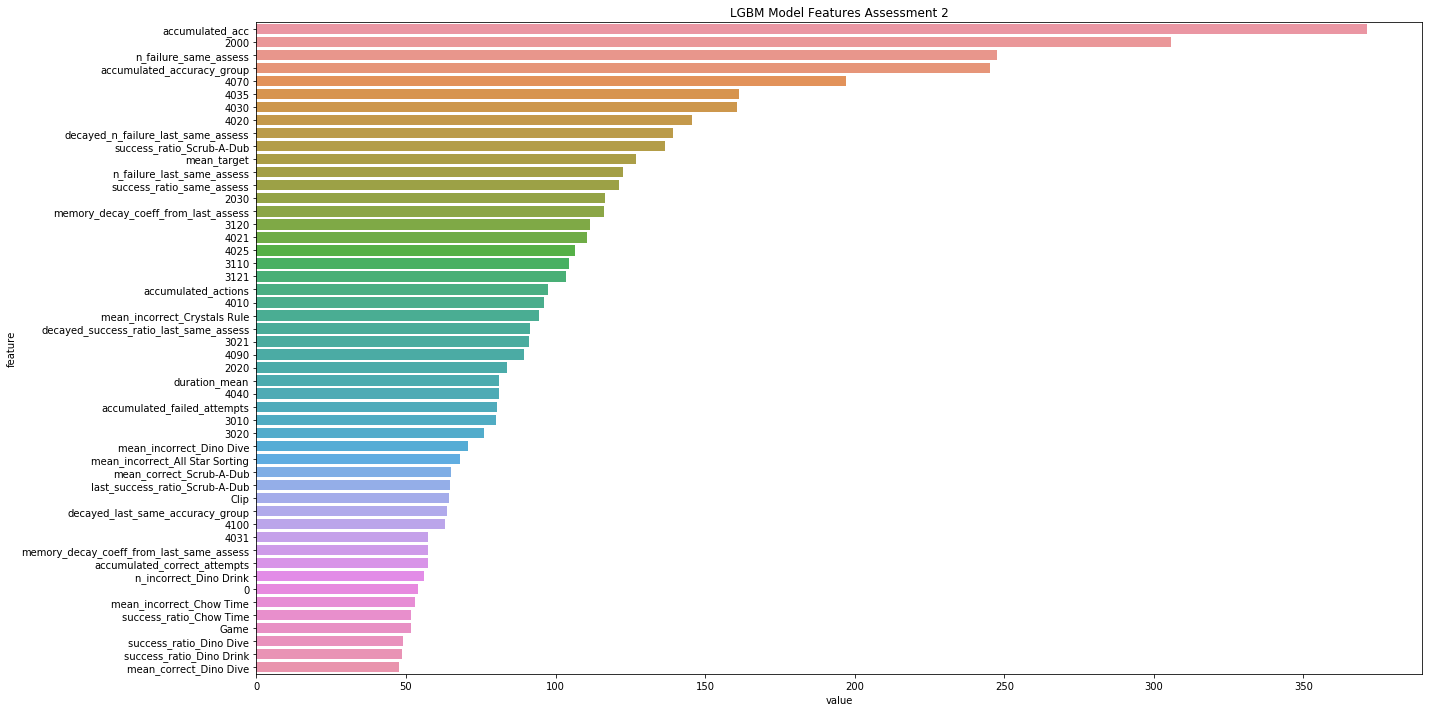

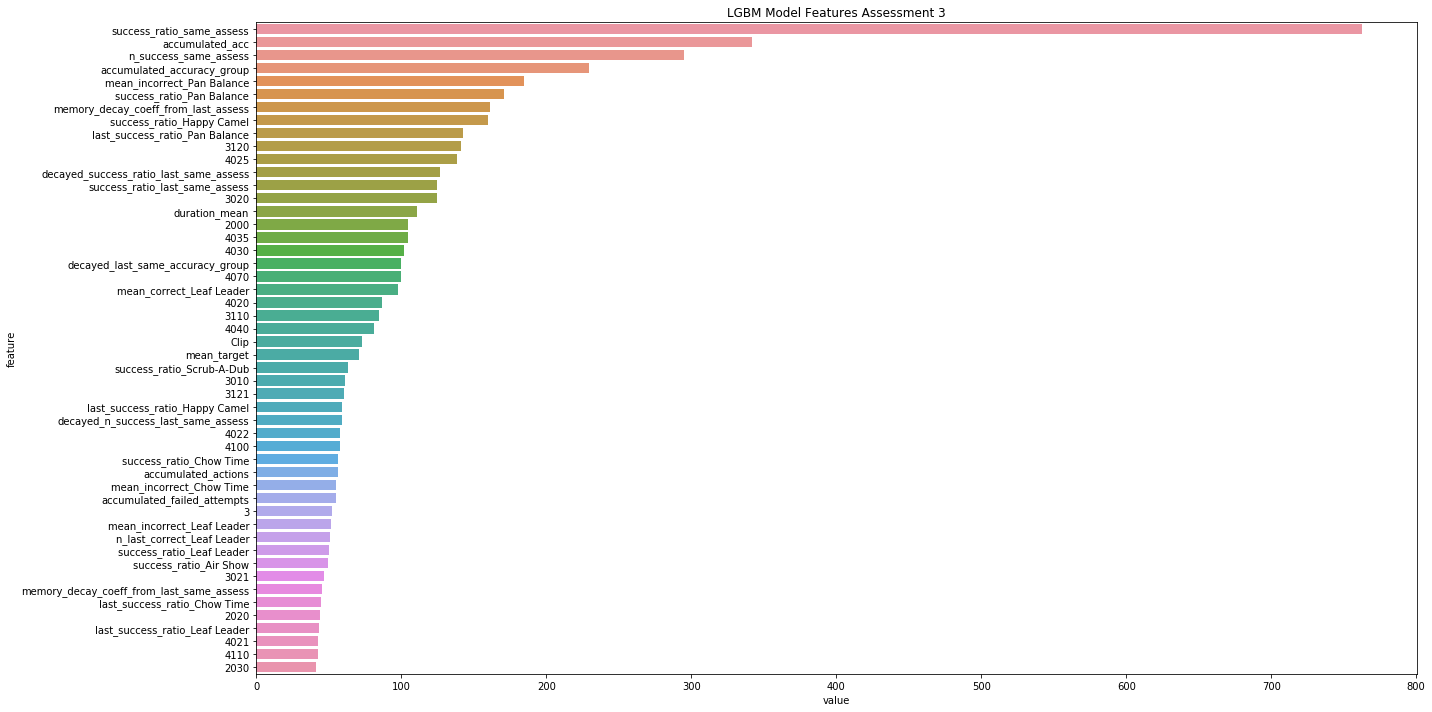

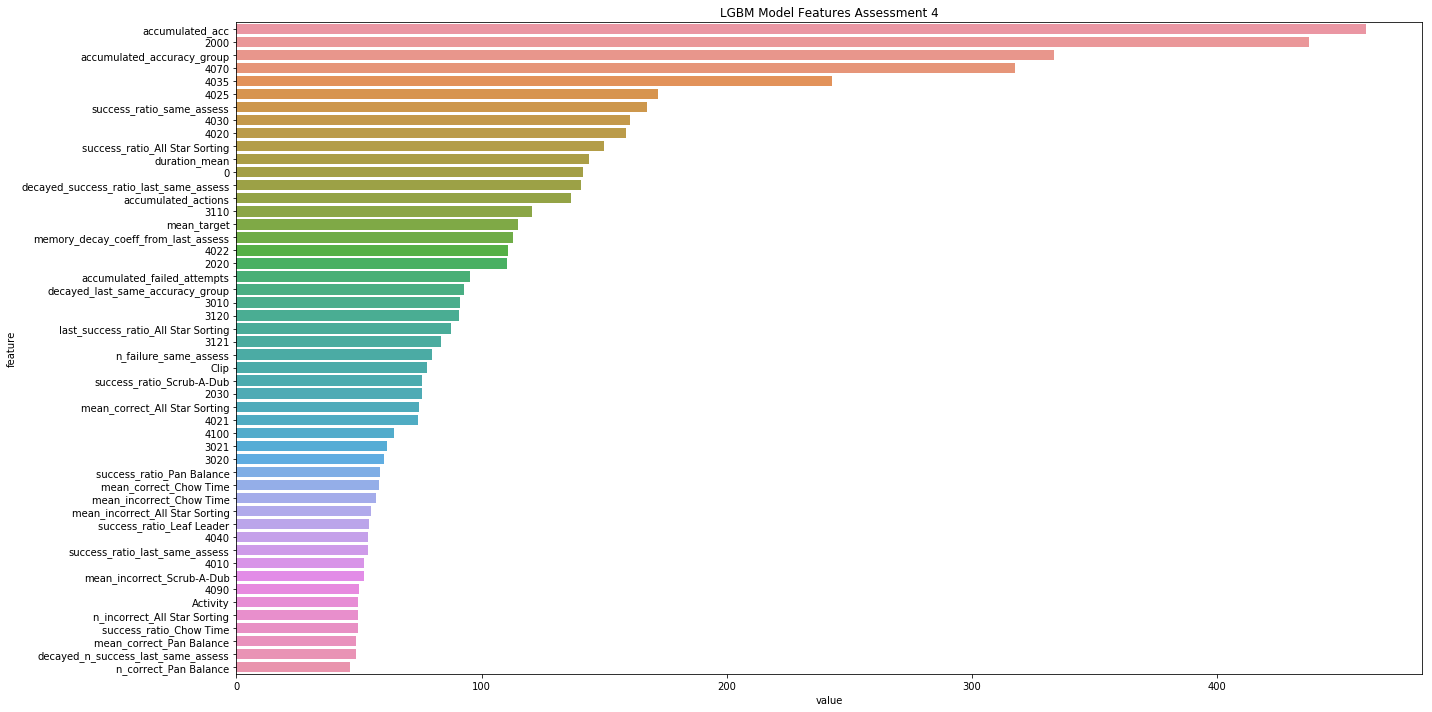

In [36]:
logging.info("Train model")

model = get_model(lgb_config)

importances = {
    i: pd.DataFrame(index=cols) for i in range(5)
}

seed_sets = [387, 289, 908, 634, 445]
for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    lgb_config["model"]["model_params"]["seed"] = seed
    lgb_config["model"]["model_params"]["drop_seed"] = seed
    lgb_config["model"]["model_params"]["bagging_seed"] = seed
    lgb_config["model"]["model_params"]["feature_fraction_seed"] = seed
    
    lgb_config["val"]["params"]["random_state"] = seed
    
    # get folds
    x_train["group"] = groups
    splits = get_validation(x_train, lgb_config)
    x_train.drop("group", axis=1, inplace=True)
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        folds_ids=splits,
        config=lgb_config,
        log=True)
    avg_oof_preds += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds += model.raw_valid_preds / (len(seed_sets) * 2)
    
    lgb_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        lgb_config[f"eval_results_seed{seed}"][k] = v
        
    for i in range(5):
        importances[i] = importances[i].join(
            feature_importance[i].to_frame().rename(
                columns={0: f"seed{seed}"}), how="inner")
    
for i in range(5):    
    feature_imp = importances[i].mean(axis=1).reset_index().rename(
        columns={
            "index": "feature",
            0: "value"
        })

    plt.figure(figsize=(20, 10))
    sns.barplot(
        x="value",
        y="feature",
        data=feature_imp.sort_values(by="value", ascending=False).head(50))
    plt.title(f"LGBM Model Features Assessment {i}")
    plt.tight_layout()
    plt.savefig(output_dir / f"feature_importance_LGBM_Assessment{i}.png")

### Save

In [37]:
save_path = output_dir / "output.json"
save_json(merged_config, save_path)

### Ensemble

In [38]:
OptR = OptimizedRounder(n_classwise=20, n_overall=20)
OptR.fit(avg_oof_preds, y_train)

oof_preds_optimized = OptR.predict(avg_oof_preds)
test_preds_optimized = OptR.predict(avg_test_preds)
valid_preds_optimized = OptR.predict(avg_valid_preds)

oof_score = calc_metric(oof_preds_optimized, y_train)
print(f"Optimized OOF QWK: {oof_score:.4f}")
valid_score = calc_metric(valid_preds_optimized, y_valid)
print(f"Optimized valid QWK: {valid_score:.4f}")

Optimized OOF QWK: 0.5943
Optimized valid QWK: 0.5863


Normalized confusion matrix
[[0.56490896 0.20406716 0.14991724 0.08110664]
 [0.2185815  0.28535877 0.29448362 0.20157611]
 [0.08888889 0.15873016 0.34240363 0.40997732]
 [0.03369135 0.08976823 0.25664217 0.61989825]]
Normalized confusion matrix
[[0.55238095 0.18571429 0.17380952 0.08809524]
 [0.2        0.25283019 0.30566038 0.24150943]
 [0.07438017 0.1322314  0.30165289 0.49173554]
 [0.03391384 0.08432631 0.24747938 0.63428048]]


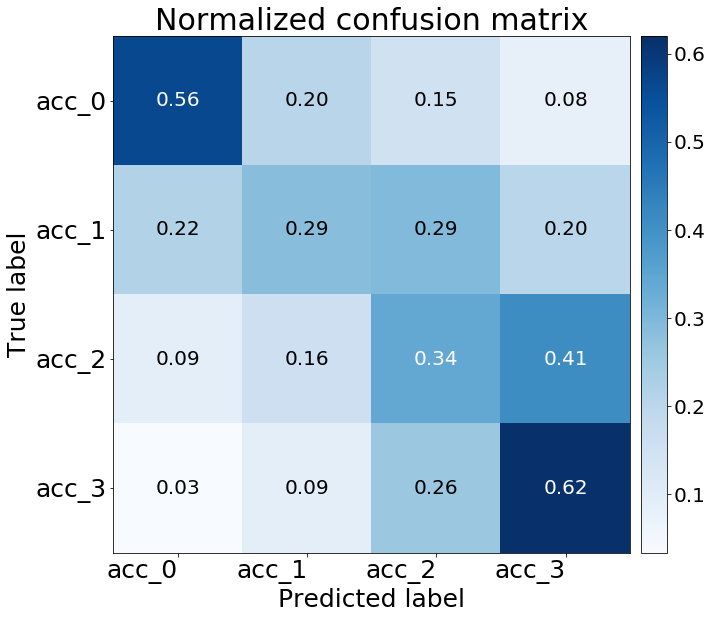

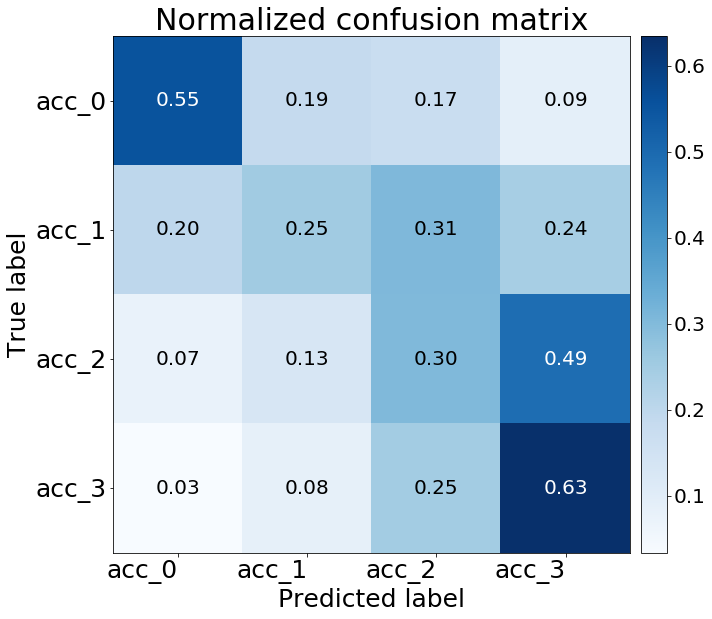

In [31]:
# Confusion Matrix
plot_confusion_matrix(
    y_train,
    oof_preds_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")
plot_confusion_matrix(
    y_valid,
    valid_preds_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_valid.png")

### Make submission

In [32]:
sample_submission = pd.read_csv(
    input_dir / "sample_submission.csv")
sample_submission["accuracy_group"] = test_preds_optimized
sample_submission.to_csv('submission.csv', index=None)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,2
3,01a44906,3
4,01bc6cb6,2
